In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
import string
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import joblib


### Part 1  prepare for training data 

In [81]:
#ibc_df = pd.read_csv('/home/jovyan/work/Analytics_Data_training/conditions_output_290419.csv')
ibc_df = pd.read_csv('/home/jovyan/work/Analytics_Data_training/conditions_with_chartids_29042019.csv')


In [3]:
ibc_df.head()

,Unnamed: 0,chart_id,created_at,submission_id,user_id,code_id,diagnosis_id,isActive,status,ai,...,evidence,selectedText,start,text,75bef,75aft,25wordsbef,25wordsaft,label,flag
0,0,IBXRMA2018_MULT_1216946630010001_HMK_166344375...,2019-04-04T01:34:25.808Z,580f20c4-425f-4923-8b72-7d78e2a8874e,russelle.p.garcia,F341,0a15e297-211e-4337-b990-1ed031e44368,True,NaN,True,...,diagnosis,NaN,8494,Dysthymic disorder,"edema, no erythema. ASSESSMENT Diagnoses a...","[ICD-10: F34.1], [ICD-9: 300.4], [SNOMED: 786...","no masses, BS normal. Extremities: FROM, no de...","[ICD-10: F34.1], [ICD-9: 300.4], [SNOMED: 786...",agreed,1
1,1,IBXRMA2018_MULT_1216946630010001_HMK_166344375...,2019-04-04T01:34:25.808Z,580f20c4-425f-4923-8b72-7d78e2a8874e,russelle.p.garcia,F341,c3b4bacd-8b23-4cb1-9637-2d12afd702c3,True,NaN,True,...,diagnosis,NaN,8522,f34.1,MENT Diagnoses attached to this encounter: ...,"], [ICD-9: 300.4], [SNOMED: 78667006] Unspec...","normal. Extremities: FROM, no deformities, no ...","], [ICD-9: 300.4], [SNOMED: 78667006] Unspec...",agreed,1
2,2,IBXRMA2018_MULT_1216946630010001_HMK_166344375...,2019-04-04T01:34:25.808Z,580f20c4-425f-4923-8b72-7d78e2a8874e,russelle.p.garcia,E039,18833cf3-b8e4-4623-81da-8df94629458a,True,NaN,True,...,diagnosis,NaN,8603,e03.9,", [ICD-9: 300.4], [SNOMED: 78667006] Unspeci...","], [ICD-9: 244.9], [SNOMED: 40930008] Mixed h...",ASSESSMENT Diagnoses attached to this encou...,"], [ICD-9: 244.9], [SNOMED: 40930008] Mixed h...",agreed,1
3,3,IBXRMA2018_MULT_1216946630010001_HMK_166344375...,2019-04-04T01:34:25.808Z,580f20c4-425f-4923-8b72-7d78e2a8874e,russelle.p.garcia,E039,6a6832d1-4976-4f8f-acdf-36079c004526,True,NaN,True,...,diagnosis,NaN,8567,Unspecified hypothyroidism,"Dysthymic disorder [ICD-10: F34.1], [ICD-9: ...","[ICD-10: E03.9], [ICD-9: 244.9], [SNOMED: 409...",no erythema. ASSESSMENT Diagnoses attached...,"[ICD-10: E03.9], [ICD-9: 244.9], [SNOMED: 409...",agreed,1
4,4,IBXRMA2018_MULT_1216946630010001_HMK_166344375...,2019-04-04T01:34:25.808Z,580f20c4-425f-4923-8b72-7d78e2a8874e,russelle.p.garcia,E782,cba1d3fb-0c79-479b-a640-8a1886925ad9,True,NaN,True,...,diagnosis,NaN,8647,Mixed hyperlipidemia,"cified hypothyroidism [ICD-10: E03.9], [ICD-9:...","[ICD-10: E78.2], [ICD-9: 272.2], [SNOMED: 267...",to this encounter: Dysthymic disorder [ICD-1...,"[ICD-10: E78.2], [ICD-9: 272.2], [SNOMED: 267...",agreed,1


In [82]:
ibc_df.columns

Index(['Unnamed: 0', 'chart_id', 'created_at', 'submission_id', 'user_id',
       'code_id', 'diagnosis_id', 'isActive', 'status', 'ai', 'annotation_id',
       'deleted', 'deleted_reason', 'end', 'evidence', 'selectedText', 'start',
       'text', '75bef', '75aft', '25wordsbef', '25wordsaft', 'label', 'flag'],
      dtype='object')

In [83]:
ibc_df['label'].value_counts()

added      79814
agreed     41794
deleted    14919
Name: label, dtype: int64

In [84]:
ibc_df['flag'].value_counts()

1    121608
0     14919
Name: flag, dtype: int64

In [85]:
ibc_df['deleted_reason'].value_counts()

other                                          9554
Wrong DOS                                      8503
not_relevant                                   2263
incorrect_spec                                 1229
Incorrect Specification - Non-Risk Adjusted     775
repeated_instance                               712
not_doctors_note                                570
incorrect_year_of_service                       493
preventative_screening                          328
negation                                        119
family_history                                   85
Active Diagnosis Code                            25
incorrect_version                                21
incorrect_acronym                                11
phoneORaddressORother_number                      9
Name: deleted_reason, dtype: int64

In [86]:
8503+2263+1229+775+712+570+493+328+119+85+25+21+11+9

15143

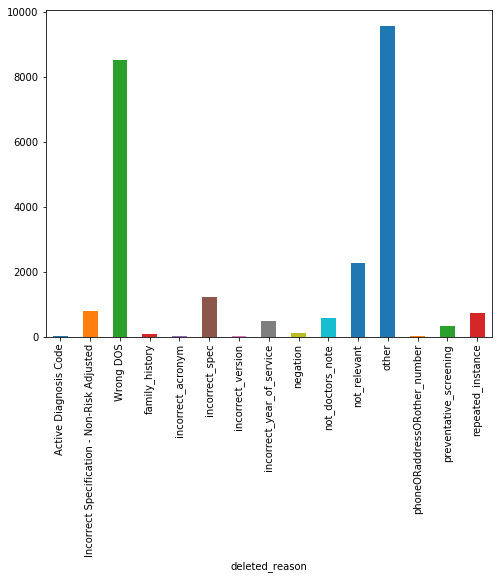

deleted_reason
Active Diagnosis Code                            25
Incorrect Specification - Non-Risk Adjusted     775
Wrong DOS                                      8503
family_history                                   85
incorrect_acronym                                11
incorrect_spec                                 1229
incorrect_version                                21
incorrect_year_of_service                       493
negation                                        119
not_doctors_note                                570
not_relevant                                   2263
other                                          9554
phoneORaddressORother_number                      9
preventative_screening                          328
repeated_instance                               712
dtype: int64

In [87]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ibc_df.groupby('deleted_reason').flag.count().plot.bar(ylim=0)
plt.show()
ibc_df.groupby(['deleted_reason']).size()  

In [88]:
# remove the 4 specific deletion reasons from dataset
print(len(ibc_df))  # before removing some data
listreason=['incorrect_year_of_service','Incorrect Specification - Non-Risk Adjusted','repeated_instance', 'incorrect_spec']
ibc_df=ibc_df[ibc_df['deleted_reason'].isin(listreason)== False]
ibc_df['deleted_reason'].unique()
print(len(ibc_df)) # a few were removed

136527
133318


In [89]:
ibc_df['label'].value_counts()

added      79814
agreed     40565
deleted    12939
Name: label, dtype: int64

In [90]:
ibc_df['flag'].value_counts()

1    120379
0     12939
Name: flag, dtype: int64

In [91]:
ibc_df['deleted_reason'].value_counts()

other                           9554
Wrong DOS                       8503
not_relevant                    2263
not_doctors_note                 570
preventative_screening           328
negation                         119
family_history                    85
Active Diagnosis Code             25
incorrect_version                 21
incorrect_acronym                 11
phoneORaddressORother_number       9
Name: deleted_reason, dtype: int64

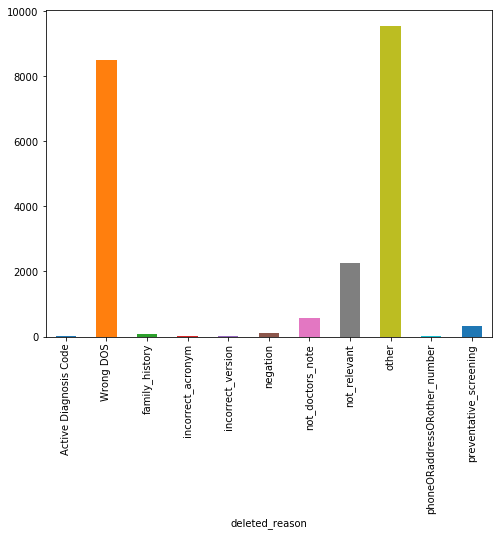

deleted_reason
Active Diagnosis Code             25
Wrong DOS                       8503
family_history                    85
incorrect_acronym                 11
incorrect_version                 21
negation                         119
not_doctors_note                 570
not_relevant                    2263
other                           9554
phoneORaddressORother_number       9
preventative_screening           328
dtype: int64

In [92]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ibc_df.groupby('deleted_reason').flag.count().plot.bar(ylim=0)
plt.show()
ibc_df.groupby(['deleted_reason']).size()  

In [93]:
# now merger 75bef and 75aft and text to make the whole 75char
ibc_df['75char']=ibc_df['75bef']+ibc_df['text']+ibc_df['75aft']

In [94]:
# doing some preprocessing or cleaning punctuation and stop words
ibc_df= ibc_df.replace(np.nan,'',regex = True)
ibc_df=ibc_df
ibc_df['text75'] = ibc_df['75char']
ibc_df = ibc_df[pd.notnull(ibc_df['text75'])] 
ibc_df['cleaned_data'] = ibc_df['text75'].apply(lambda x: x.lower())
ibc_df['cleaned_data'] = ibc_df['cleaned_data'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))

# remove stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

ibc_df['cleaned_data']= ibc_df['cleaned_data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
ibc_df['cleaned_data']= ibc_df['cleaned_data'].str.findall('\w{2,}').str.join(' ')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
ibc_df.reset_index(drop=True)
ibc_df.tail()

,Unnamed: 0,chart_id,created_at,submission_id,user_id,code_id,diagnosis_id,isActive,status,ai,...,text,75bef,75aft,25wordsbef,25wordsaft,label,flag,75char,text75,cleaned_data
136522,563808,IBXRMA2018_MULT_1200195330010001_HMK_197464373...,2019-03-20T11:03:26.826Z,778a7ce8-c9ef-4d33-9ae9-25176ce75034,h.sathyanarayanamur,E849,a64ef5c7-ad59-4960-a75c-3aaeca244a89,True,undocumented,False,...,Cystic fibrosis,"Grill, MaryTheresa 000000001141 07/22/1954 06...",gene05/15/1989Y carrier History of polyp ...,Chronic deafness06/06/2017Y HLD - Hyperlipi...,gene05/15/1989Y carrier History of polyp ...,added,1,"Grill, MaryTheresa 000000001141 07/22/1954 06...","Grill, MaryTheresa 000000001141 07/22/1954 06...",grill marytheresa 000000001141 07221954 060620...
136523,563809,IBXRMA2018_MULT_1200195330010001_HMK_197464373...,2019-03-20T11:03:26.826Z,778a7ce8-c9ef-4d33-9ae9-25176ce75034,h.sathyanarayanamur,E849,a855743b-f371-47c4-995d-0c9295acff54,True,undocumented,False,...,Cystic fibrosis,situ Chronic deafness06/06/2017Y HLD - H...,gene05/15/1989Y carrier History of polyp o...,Problem DescriptionOnset DateChronicClinical S...,gene05/15/1989Y carrier History of polyp o...,added,1,situ Chronic deafness06/06/2017Y HLD - H...,situ Chronic deafness06/06/2017Y HLD - H...,situ chronic deafness06062017y hld hyperlipida...
136524,563810,IBXRMA2018_MULT_1200195330010001_HMK_197464373...,2019-03-20T11:03:26.826Z,778a7ce8-c9ef-4d33-9ae9-25176ce75034,h.sathyanarayanamur,E849,a79c0e1d-f761-4320-a033-b1ecb6760c5a,True,undocumented,False,...,Cystic fibrosis,situ Chronic deafness06/06/2017Y HLD - H...,gene05/15/1989Y carrier History of polyp o...,Problem DescriptionOnset DateChronicClinical S...,gene05/15/1989Y carrier History of polyp o...,added,1,situ Chronic deafness06/06/2017Y HLD - H...,situ Chronic deafness06/06/2017Y HLD - H...,situ chronic deafness06062017y hld hyperlipida...
136525,563811,IBXRMA2018_MULT_1200195330010001_HMK_197464373...,2019-03-20T11:03:26.826Z,778a7ce8-c9ef-4d33-9ae9-25176ce75034,h.sathyanarayanamur,K219,e495e09c-667f-4987-b997-bd2f21ff19b6,True,undocumented,False,...,Gastroesophageal Y\nreflux disease,,"Grill, MaryTheresa DOB: 07/22/1954 CONTENTS...",,"NextGen Patient Record Name: Grill, Mary...",added,1,,,
136526,563812,IBXRMA2018_MULT_1200195330010001_HMK_197464373...,2019-03-20T11:03:26.826Z,778a7ce8-c9ef-4d33-9ae9-25176ce75034,h.sathyanarayanamur,K219,31bfd563-fd40-4cd4-994f-0a5d1da114c5,True,undocumented,False,...,Gastroesophageal Y\nreflux disease,,"Grill, MaryTheresa DOB: 07/22/1954 CONTENTS...",,"NextGen Patient Record Name: Grill, Mary...",added,1,,,


### set aside 1000 charts as testing charts  from AM's selected 1000 charts

In [96]:
ibc_df['chart_id'].nunique() 

5970

In [97]:
# 1000 charts
chartlist=pd.read_csv('newmodel_charts2.csv')

In [98]:
chartlist.head()

,Unnamed: 0,chart_id
0,0,IBXRMA2018_MULT_1215988930010001_HMK_203445469...
1,1,IBXRMA2018_MULT_1216836820010001_HMK_183382865...
2,2,IBXRMA2018_MULT_1217953950010001_HMK_194369925...
3,3,IBXRMA2018_MULT_1198751560010001_HMK_178444167...
4,4,IBXRMA2018_MULT_1218023650010001_HMK_201301197...


In [99]:
chart_list=chartlist['chart_id'].tolist()
print(len(chart_list))
print(len(set(chart_list)))

1044
1044


In [100]:
# select the data not in this list only
print(ibc_df['chart_id'].nunique())
traindata=ibc_df[ibc_df['chart_id'].isin(chart_list)==False]
print(traindata['chart_id'].nunique())

5970
5146


In [101]:
traindata[traindata['flag']==0]['deleted_reason'].unique()

array(['other', 'negation', 'preventative_screening', 'not_doctors_note',
       'not_relevant', 'family_history', 'incorrect_acronym',
       'phoneORaddressORother_number'], dtype=object)

### Load previous IBC data

In [102]:
trainDFold=pd.read_csv('/home/jovyan/work/Analytics_Data_training/ibc_trainingdata_040219.csv')  #  using prvious dataset 
testDFold=pd.read_csv('/home/jovyan/work/Analytics_Data_training/ibc_testingdata_040219.csv')
allprevious_ibc_df=pd.concat([trainDFold,testDFold])

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [119]:
allprevious_ibc_d2f=pd.read_csv('/home/jovyan/work/Analytics_Data_training/IBC_data_260319_1.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [121]:
allprevious_ibc_d2f['deleted_reason'].value_counts()

not_relevant                                   63361
not_doctors_note                               35074
Incorrect Specification - Non-Risk Adjusted    30514
negation                                       29691
other                                          19345
family_history                                 15494
preventative_screening                         14616
incorrect_spec                                 12728
phoneORaddressORother_number                    5250
repeated_instance                               5199
incorrect_year_of_service                       3370
incorrect_acronym                               3172
medical_history                                 1201
incorrect_version                                  6
Name: deleted_reason, dtype: int64

In [137]:
'''
# this is just for family history reason data check
test1=allprevious_ibc_d2f[allprevious_ibc_d2f['deleted_reason']=='family_history']

test2=allprevious_ibc_d2f[pd.notnull(allprevious_ibc_d2f['deleted_reason'])] 

test2=test2[pd.notnull(test2['75char'])] 
test2=test2[test2['deleted_reason']!='family_history']
#test2=allprevious_ibc_d2f[allprevious_ibc_d2f['deleted_reason']!='family_history']
print(len(test1))
print(len(test2))

print(len(test1[test1['75char'].str.contains('family history',flags=re.IGNORECASE)]))
print(len(test2[test2['75char'].str.contains('family history',flags=re.IGNORECASE)]))
'''

15494
223477
7113
2956


In [104]:
allprevious_ibc_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'chart_id', 'code_id', 'text',
       'start_offset', 'end_offset', 'deleted_reason', 'deleted', 'label',
       '15char', '25char', '50char', '75char', '10word_after', '10word_before',
       '50word_after', '50word_before', 'flag', 'text75', 'cleaned_data'],
      dtype='object')

In [117]:
allprevious_ibc_df['chart_id'].nunique()

41025

In [105]:
allprevious_ibc_df['flag'].value_counts()

1    193800
0    173651
Name: flag, dtype: int64

In [106]:
allprevious_ibc_df['label'].value_counts()

deleted    193800
added       95563
agreed      78088
Name: label, dtype: int64

In [107]:
allprevious_ibc_df['flag']=1-allprevious_ibc_df['flag']  # need to reverse the flag, because 1 is agreed, not deleted

In [108]:
# from ibc 2017 data
charttrainlist=allprevious_ibc_df['chart_id'].unique()
print(len(charttrainlist))

# below is from 5000 charts from recent chart review
charttrainnewlist=traindata['chart_id'].unique()
print(len(charttrainnewlist))

41025
5146


In [109]:
# check if there's overlap, there shouldn't be any
print(len(list(set(charttrainlist)&set(charttrainnewlist))))   # if is 0, no overlap

0


In [110]:
traindata.columns

Index(['Unnamed: 0', 'chart_id', 'created_at', 'submission_id', 'user_id',
       'code_id', 'diagnosis_id', 'isActive', 'status', 'ai', 'annotation_id',
       'deleted', 'deleted_reason', 'end', 'evidence', 'selectedText', 'start',
       'text', '75bef', '75aft', '25wordsbef', '25wordsaft', 'label', 'flag',
       '75char', 'text75', 'cleaned_data'],
      dtype='object')

In [111]:
allprevious_ibc_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'chart_id', 'code_id', 'text',
       'start_offset', 'end_offset', 'deleted_reason', 'deleted', 'label',
       '15char', '25char', '50char', '75char', '10word_after', '10word_before',
       '50word_after', '50word_before', 'flag', 'text75', 'cleaned_data'],
      dtype='object')

In [112]:
# select so these two have the same columns
traindata=traindata[['chart_id','code_id','start','end','flag','text','deleted_reason','cleaned_data','label']]
trainibcold=allprevious_ibc_df[['chart_id','code_id','start_offset','end_offset','flag','text','deleted_reason','cleaned_data','label']]
trainibcold.columns=['chart_id','code_id','start','end','flag','text','deleted_reason','cleaned_data','label']

In [113]:
print(len(traindata))
print(len(trainibcold))

103254
367451


In [114]:
# now combine these two data
alltrainDF=pd.concat([traindata,trainibcold])
print(len(alltrainDF))

470705


In [115]:
alltrainDF=alltrainDF[['chart_id','code_id','start','end','flag','text','deleted_reason','cleaned_data','label']].drop_duplicates()
len(alltrainDF)

467792

In [118]:
alltrainDF['chart_id'].nunique()

46171

In [116]:
alltrainDF.to_csv('traindf_foribcupdated_0528.csv')

In [41]:
# check if there's duplicate
testalllen=alltrainDF[['chart_id','code_id','start','end','flag','text']].drop_duplicates()
len(testalllen)

467531

In [54]:
testalllen1=alltrainDF[['chart_id','code_id','start','end','flag']].drop_duplicates()
len(testalllen1)

466233

In [55]:
testalllen2=alltrainDF[['chart_id','code_id','start','end']].drop_duplicates()
len(testalllen2)

462666

In [56]:
alldf=pd.merge(alltrainDF,testalllen2,how = 'inner', on = ['chart_id','code_id','start','end'])
len(alldf)

467754

In [57]:
alldf.columns

Index(['chart_id', 'code_id', 'start', 'end', 'flag', 'text', 'deleted_reason',
       'cleaned_data'],
      dtype='object')

In [58]:
alldf['deleted_reason'].value_counts()

                                84896
not_relevant                    64989
not_doctors_note                35494
negation                        29750
other                           26723
family_history                  15537
preventative_screening          14859
Wrong DOS                        6314
phoneORaddressORother_number     5253
incorrect_acronym                3171
medical_history                  1189
incorrect_version                  25
Active Diagnosis Code              17
Name: deleted_reason, dtype: int64

In [49]:
alldf['deleted_reason'].isnull().sum()

179537

In [52]:
64989+35494+29750+26723+15537+14859+6314+5253+3171+1189+25+17+84896+179537

467754